<a href="https://colab.research.google.com/github/seemab21/Thesis_Transformer_model/blob/main/Overlap_2_IHR_Data_Visualization_Activity_Label_Recg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hyperparameter	Value


frame_size (sequence length)	100


feature_cols	6 features (acceleration X,Y,Z + angular X,Y,Z)


d_model (embedding size)	64


n_head (attention heads)	4


n_layers (encoder layers)	2


hidden (feedforward size)	128


dropout	0.3


n_classes	4 (HES, HER, TOF, FOF)


batch_size	32


learning_rate	5e-5


optimizer	AdamW (weight_decay=1e-4)


epochs	50


loss_fn	Focal Loss (γ=2, α=class weights)


cross-validation folds	5

In [1]:
import os, math, copy, torch
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn, torch.nn.functional as F
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ========================== CONFIG ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
frame_size = 100
overlap = 0.5
step_size = int(frame_size * (1 - overlap))
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'left angular X[dps]',
    'left angular Y[dps]',
    'left angular Z[dps]',
]
label_map = {'HES':0,'HER':1,'TOF':2,'FOF':3}

# ========================== DATASET ==============================
class IMUDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1, frame_size, len(feature_cols))
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self): return len(self.Y)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]


In [3]:
def process_file(filepath, overlap=0.5):
    df = pd.read_excel(filepath)
    df = df.dropna(subset=feature_cols+['Event- Label level 2- Left Foot'])
    df['label'] = df['Event- Label level 2- Left Foot'].map(label_map)
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    frames, labels = [], []
    step = int(frame_size * (1 - overlap))
    for i in range(0, len(df) - frame_size + 1, step):
        segment = df.iloc[i:i+frame_size]
        label = np.bincount(segment['label']).argmax()
        frames.append(segment[feature_cols].values.flatten())
        labels.append(label)
    return frames, labels

def load_all_group_data(root_dir, groups):

    all_frames, all_labels = [], []
    print("\nLoading data...")
    for group in groups:
        group_path = os.path.join(root_dir, group)
        for file in os.listdir(group_path):
            if file.endswith('.xlsx'):
                try:
                    frames, labels = process_file(os.path.join(group_path, file))
                    # Ensure frames and labels are lists before extending
                    all_frames += list(frames)
                    all_labels += list(labels)
                except KeyError as e:
                    print(f"File skipped due to missing columns: {file}")
                    print(f"Missing columns error: {e}")
                    continue

    all_frames, all_labels = np.array(all_frames), np.array(all_labels)
    print("Loaded:", all_frames.shape, "Labels:", Counter(all_labels))

    counts = Counter(all_labels)
    plt.figure(figsize=(6,4))
    plt.bar([list(label_map.keys())[i] for i in counts.keys()], counts.values(), color='skyblue')
    plt.title('Class Distribution After Loading Data')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.show()

        # Compute stats
    total_samples = len(all_labels)
    total_frames = all_frames.shape[0]
    counts = Counter(all_labels)

    print("\n===== DATA SUMMARY =====")
    print(f"Total Samples: {total_samples}")
    print(f"Total Frames:  {total_frames}")
    print("Class Distribution:")
    for class_idx, count in counts.items():
        class_name = list(label_map.keys())[class_idx]
        print(f"  {class_name}: {count}")

    # Plot bar chart for class distribution
    plt.figure(figsize=(6, 4))
    class_names = [list(label_map.keys())[i] for i in counts.keys()]
    plt.bar(class_names, counts.values(), color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.show()

    return all_frames, all_labels


In [4]:
import glob


Loading data...
File skipped due to missing columns: pd004_1norm2.xlsx
Missing columns error: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]']
Loaded: (6973, 600) Labels: Counter({np.int64(2): 3566, np.int64(3): 1730, np.int64(0): 1202, np.int64(1): 475})


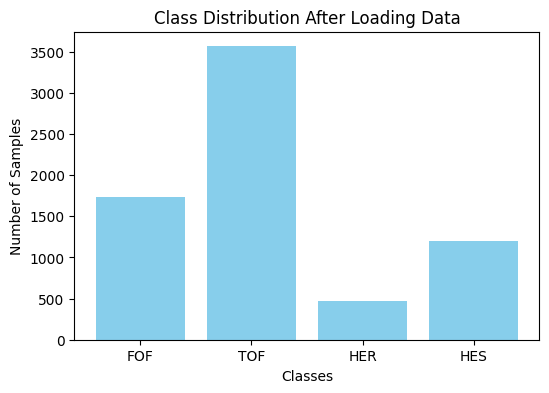


===== DATA SUMMARY =====
Total Samples: 6973
Total Frames:  6973
Class Distribution:
  FOF: 1730
  TOF: 3566
  HER: 475
  HES: 1202


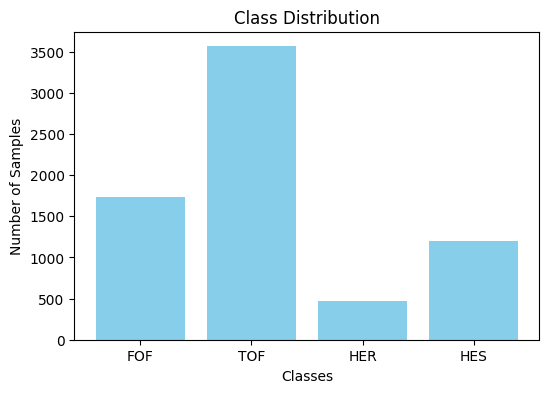

Visualizing signal from: pd004_1slow2.xlsx


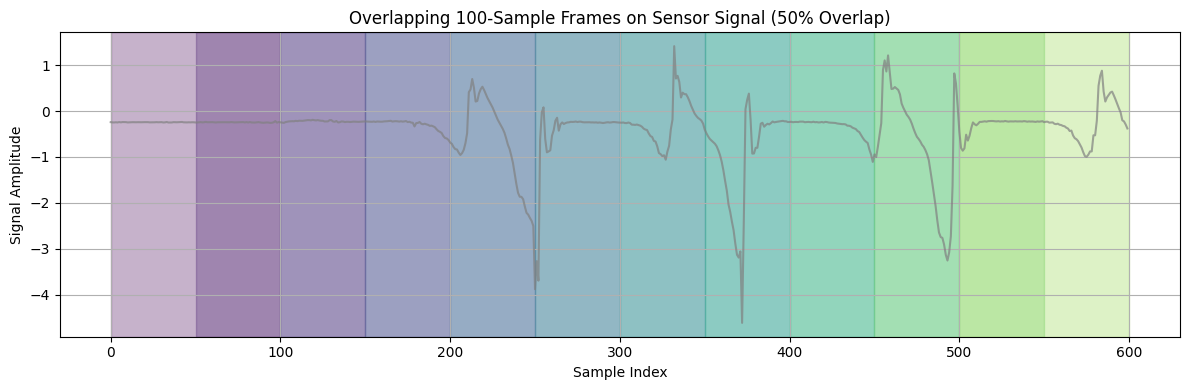

In [5]:
# ========== RUN LOADER ==========
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['PD', 'S']
frames, labels = load_all_group_data(root_dir, groups)

# ========== VISUALIZE OVERLAPPING SEGMENTS ==========
# Find all .xlsx files in PD group (you can choose 'S' as well)
pd_folder = os.path.join(root_dir, 'PD')
excel_files = glob.glob(os.path.join(pd_folder, '*.xlsx'))

if excel_files:
    sample_file = excel_files[0]  # Just take the first one for visualization
    print(f"Visualizing signal from: {os.path.basename(sample_file)}")

    df = pd.read_excel(sample_file)
    df = df.dropna(subset=feature_cols + ['Event- Label level 2- Left Foot'])

    signal = df['left acceleration X[g]'].values[:600]

    plt.figure(figsize=(12, 4))
    plt.plot(signal, label='Sensor Signal', color='gray', alpha=0.7)

    for i in range(0, len(signal) - frame_size + 1, step_size):
        frame_start = i
        frame_end = i + frame_size
        color = plt.cm.viridis(i / len(signal))
        plt.axvspan(frame_start, frame_end, color=color, alpha=0.3)

    plt.title('Overlapping 100-Sample Frames on Sensor Signal (50% Overlap)')
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No Excel files found in PD folder.")

In [6]:
# ===================== TRANSFORMER MODEL =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self,x):
        return x+self.pe[:,:x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,n_head):
        super().__init__(); self.n_head=n_head; self.d_head=d_model//n_head
        self.qkv=nn.Linear(d_model,3*d_model); self.o=nn.Linear(d_model,d_model)
    def forward(self,x):
        B,T,C=x.shape
        qkv=self.qkv(x).reshape(B,T,3,self.n_head,self.d_head).permute(2,0,3,1,4)
        q,k,v=qkv[0],qkv[1],qkv[2]
        attn=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.d_head)
        attn=attn.softmax(-1)
        out=torch.matmul(attn,v).transpose(1,2).reshape(B,T,C)
        return self.o(out)

class FeedForward(nn.Module):
    def __init__(self,d_model,hidden,drop=0.3):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(d_model,hidden),nn.ReLU(),nn.Dropout(drop),nn.Linear(hidden,d_model))
    def forward(self,x): return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self,d_model,n_head,hidden,drop=0.3):
        super().__init__()
        self.attn=MultiHeadAttention(d_model,n_head)
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.ff=FeedForward(d_model,hidden,drop)
    def forward(self,x):
        x=self.norm1(x+self.attn(x))
        return self.norm2(x+self.ff(x))

class TransformerModel(nn.Module):
    def __init__(self,d_model=64,n_head=4,n_layers=2,hidden=128,n_classes=4,seq_len=100):
        super().__init__()
        self.proj=nn.Sequential(nn.Linear(6,d_model),nn.BatchNorm1d(seq_len))
        self.pos=PositionalEncoding(d_model)
        self.layers=nn.ModuleList([EncoderLayer(d_model,n_head,hidden) for _ in range(n_layers)])
        self.head=nn.Sequential(nn.Flatten(),nn.Linear(d_model*seq_len,256),nn.ReLU(),nn.Dropout(0.3),nn.Linear(256,n_classes))
    def forward(self,x):
        x=self.proj(x); x=self.pos(x)
        for layer in self.layers: x=layer(x)
        return self.head(x)

# ==================== LOSS FUNCTION ===============================
class FocalLoss(nn.Module):
    def __init__(self,alpha=None,gamma=2):
        super().__init__(); self.alpha=alpha; self.gamma=gamma
        self.ce=nn.CrossEntropyLoss(weight=alpha)
    def forward(self,inputs,targets):
        ce_loss=self.ce(inputs,targets)
        pt=torch.exp(-ce_loss)
        return ((1-pt)**self.gamma*ce_loss).mean()

In [7]:
# ==================== TRAINING UTILS ==============================
def train_one_epoch(model,loader,opt,scaler,loss_fn):
    model.train(); total_loss=0; correct=0; total=0
    for x,y in loader:
        x,y=x.to(device),y.to(device); opt.zero_grad()
        with autocast():
            out=model(x); loss=loss_fn(out,y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        total_loss+=loss.item()*x.size(0)
        correct+=(out.argmax(1)==y).sum().item(); total+=y.size(0)
    return total_loss/total, correct/total

def validate(model,loader,loss_fn):
    model.eval(); total_loss=0; correct=0; total=0; preds=[]; labels=[]
    with torch.no_grad():
        for x,y in loader:
            x,y=x.to(device),y.to(device)
            out=model(x); loss=loss_fn(out,y)
            total_loss+=loss.item()*x.size(0)
            correct+=(out.argmax(1)==y).sum().item(); total+=y.size(0)
            preds.extend(out.argmax(1).cpu().numpy()); labels.extend(y.cpu().numpy())
    return total_loss/total, correct/total, preds, labels

In [8]:
# ==================== CROSS VALIDATION =============================
def cross_validate(frames,labels,root_dir,k=5,epochs=50,batch_size=32,lr=1e-4):
    skf=StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    results=[]; scaler=StandardScaler(); frames=scaler.fit_transform(frames)
    weights=compute_class_weight('balanced',classes=np.arange(4),y=labels)
    alpha=torch.tensor(weights,dtype=torch.float32).to(device)

    for fold,(tr,va) in enumerate(skf.split(frames,labels),1):
        print(f"\n===== Fold {fold}/{k} =====")
        Xtr,Ytr=frames[tr],labels[tr]; Xva,Yva=frames[va],labels[va]
        ros=RandomOverSampler(sampling_strategy='auto'); Xtr,Ytr=ros.fit_resample(Xtr,Ytr)
        print("After oversampling:",Counter(Ytr))

        counts = Counter(Ytr)
        plt.figure(figsize=(6,4))
        plt.bar([list(label_map.keys())[i] for i in counts.keys()], counts.values(), color='orange')
        plt.title(f'Class Distribution Fold {fold} (Train After Oversampling)')
        plt.xlabel('Classes')
        plt.ylabel('Number of Samples')
        plt.show()

        train_loader=DataLoader(IMUDataset(Xtr,Ytr),batch_size=batch_size,shuffle=True)
        val_loader=DataLoader(IMUDataset(Xva,Yva),batch_size=batch_size)

        model=TransformerModel().to(device)
        opt=AdamW(model.parameters(),lr=lr,weight_decay=1e-4)
        loss_fn=FocalLoss(alpha)
        amp_scaler=GradScaler()

        patience = 20  # ⏳ Added patience
        best_epoch = 0
        best_acc = 0
        best_wts = copy.deepcopy(model.state_dict())
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        for ep in range(epochs):
            tr_loss,tr_acc=train_one_epoch(model,train_loader,opt,amp_scaler,loss_fn)
            va_loss,va_acc,preds,labs=validate(model,val_loader,loss_fn)

            current_lr = opt.param_groups[0]['lr']
            print(f"Epoch {ep+1}: LR={current_lr:.6f} | Train Acc={tr_acc:.3f} | Val Acc={va_acc:.3f}")

            history["train_loss"].append(tr_loss)
            history["val_loss"].append(va_loss)
            history["train_acc"].append(tr_acc)
            history["val_acc"].append(va_acc)

            print(f"Epoch {ep+1}: Train Acc={tr_acc:.3f} | Val Acc={va_acc:.3f}")

            if va_acc > best_acc:
                best_acc = va_acc
                best_epoch = ep
                best_wts = copy.deepcopy(model.state_dict())
                print(f"Best model saved at epoch {ep+1} with Val Acc={va_acc:.4f}")

            elif ep - best_epoch >= patience:
                print(f"Early stopping at epoch {ep+1}")
                break

        # Plot loss and accuracy curves for this fold
        epochs_range = range(1, len(history["train_loss"])+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs_range, history["train_loss"], label="Train Loss")
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
        plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title(f"Fold {fold} Loss")

        plt.subplot(1,2,2)
        plt.plot(epochs_range, history["train_acc"], label="Train Acc")
        plt.plot(epochs_range, history["val_acc"], label="Val Acc")
        plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"Fold {fold} Accuracy")
        plt.show()

        model.load_state_dict(best_wts)
        acc,prec,rec,f1=(accuracy_score(labs,preds),precision_score(labs,preds,average='weighted'),
                         recall_score(labs,preds,average='weighted'),f1_score(labs,preds,average='weighted'))
        print(f"Fold {fold} Final: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

        torch.save(model.state_dict(),f"{root_dir}/transformer_fold{fold}.pth")
        cm=confusion_matrix(labs,preds)
        sns.heatmap(cm,annot=True,fmt='d',xticklabels=label_map.keys(),yticklabels=label_map.keys())
        plt.title(f"Confusion Matrix Fold {fold}"); plt.show()

        results.append({'fold':fold,'acc':acc,'prec':prec,'rec':rec,'f1':f1})

    df=pd.DataFrame(results); df.to_csv(f"{root_dir}/cv_metrics.csv",index=False)
    print("\nAverage:",df[['acc','prec','rec','f1']].mean())
    return df



===== Fold 1/5 =====
After oversampling: Counter({np.int64(3): 2852, np.int64(2): 2852, np.int64(1): 2852, np.int64(0): 2852})


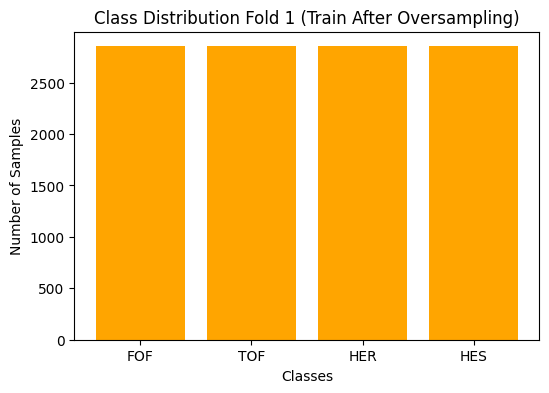

/tmp/ipython-input-444597368.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: LR=0.000050 | Train Acc=0.438 | Val Acc=0.411
Epoch 1: Train Acc=0.438 | Val Acc=0.411
Best model saved at epoch 1 with Val Acc=0.4108
Epoch 2: LR=0.000050 | Train Acc=0.559 | Val Acc=0.505
Epoch 2: Train Acc=0.559 | Val Acc=0.505
Best model saved at epoch 2 with Val Acc=0.5054
Epoch 3: LR=0.000050 | Train Acc=0.604 | Val Acc=0.446
Epoch 3: Train Acc=0.604 | Val Acc=0.446
Epoch 4: LR=0.000050 | Train Acc=0.638 | Val Acc=0.490
Epoch 4: Train Acc=0.638 | Val Acc=0.490
Epoch 5: LR=0.000050 | Train Acc=0.664 | Val Acc=0.551
Epoch 5: Train Acc=0.664 | Val Acc=0.551
Best model saved at epoch 5 with Val Acc=0.5505
Epoch 6: LR=0.000050 | Train Acc=0.693 | Val Acc=0.546
Epoch 6: Train Acc=0.693 | Val Acc=0.546
Epoch 7: LR=0.000050 | Train Acc=0.703 | Val Acc=0.543
Epoch 7: Train Acc=0.703 | Val Acc=0.543
Epoch 8: LR=0.000050 | Train Acc=0.723 | Val Acc=0.586
Epoch 8: Train Acc=0.723 | Val Acc=0.586
Best model saved at epoch 8 with Val Acc=0.5864
Epoch 9: LR=0.000050 | Train Acc=0.733 |

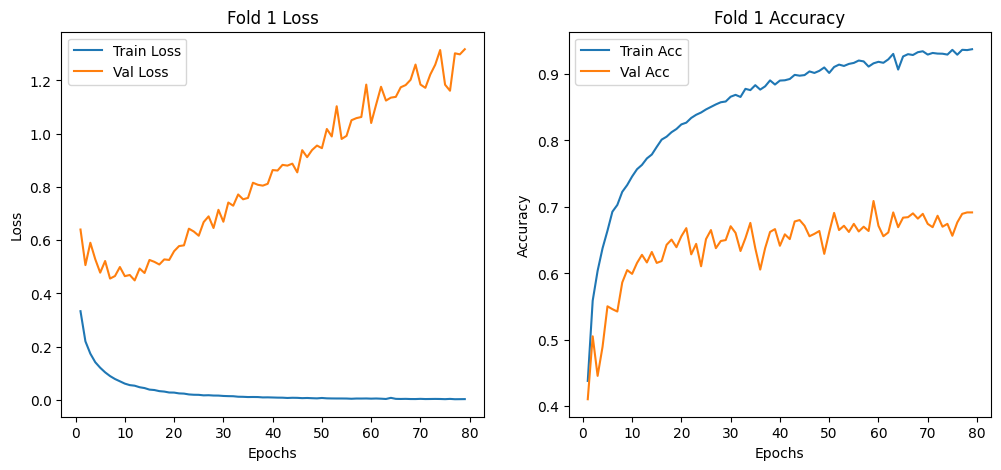

Fold 1 Final: Acc=0.692 Prec=0.701 Rec=0.692 F1=0.695


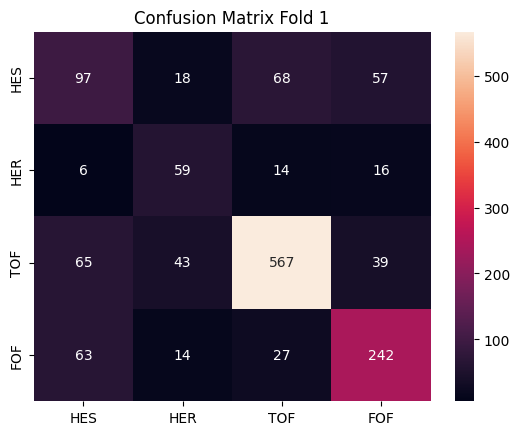


===== Fold 2/5 =====
After oversampling: Counter({np.int64(3): 2853, np.int64(2): 2853, np.int64(1): 2853, np.int64(0): 2853})


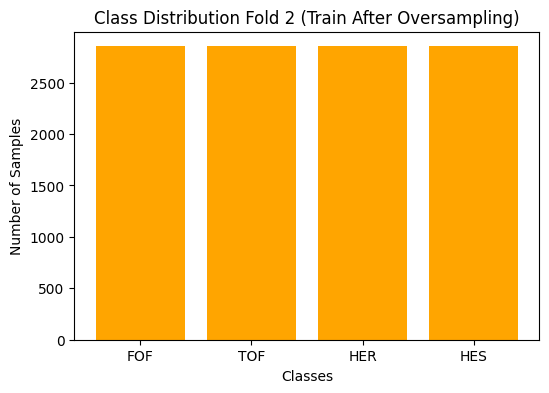

/tmp/ipython-input-444597368.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: LR=0.000050 | Train Acc=0.416 | Val Acc=0.191
Epoch 1: Train Acc=0.416 | Val Acc=0.191
Best model saved at epoch 1 with Val Acc=0.1907
Epoch 2: LR=0.000050 | Train Acc=0.542 | Val Acc=0.427
Epoch 2: Train Acc=0.542 | Val Acc=0.427
Best model saved at epoch 2 with Val Acc=0.4272
Epoch 3: LR=0.000050 | Train Acc=0.600 | Val Acc=0.447
Epoch 3: Train Acc=0.600 | Val Acc=0.447
Best model saved at epoch 3 with Val Acc=0.4473
Epoch 4: LR=0.000050 | Train Acc=0.632 | Val Acc=0.553
Epoch 4: Train Acc=0.632 | Val Acc=0.553
Best model saved at epoch 4 with Val Acc=0.5527
Epoch 5: LR=0.000050 | Train Acc=0.661 | Val Acc=0.527
Epoch 5: Train Acc=0.661 | Val Acc=0.527
Epoch 6: LR=0.000050 | Train Acc=0.677 | Val Acc=0.573
Epoch 6: Train Acc=0.677 | Val Acc=0.573
Best model saved at epoch 6 with Val Acc=0.5728
Epoch 7: LR=0.000050 | Train Acc=0.698 | Val Acc=0.581
Epoch 7: Train Acc=0.698 | Val Acc=0.581
Best model saved at epoch 7 with Val Acc=0.5806
Epoch 8: LR=0.000050 | Train Acc=0.715 |

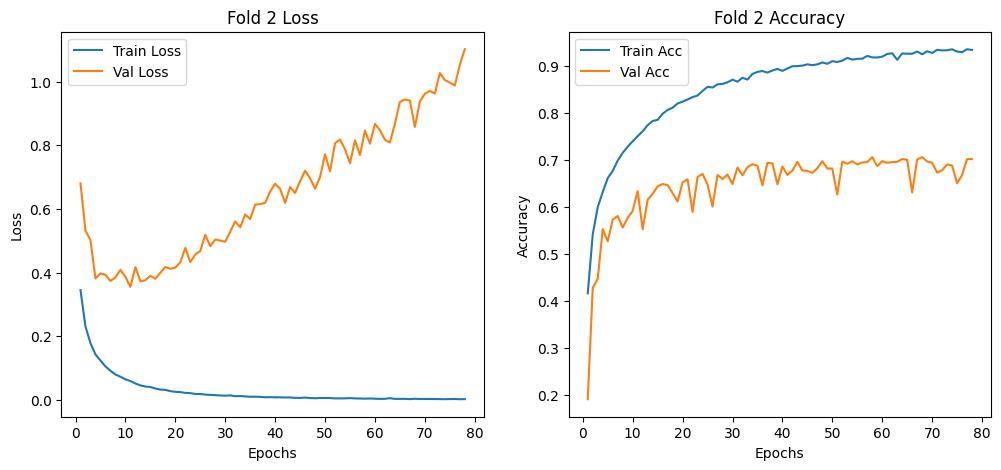

Fold 2 Final: Acc=0.702 Prec=0.700 Rec=0.702 F1=0.700


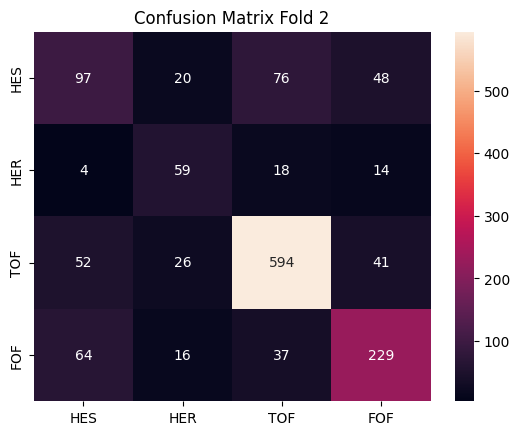


===== Fold 3/5 =====
After oversampling: Counter({np.int64(3): 2853, np.int64(1): 2853, np.int64(2): 2853, np.int64(0): 2853})


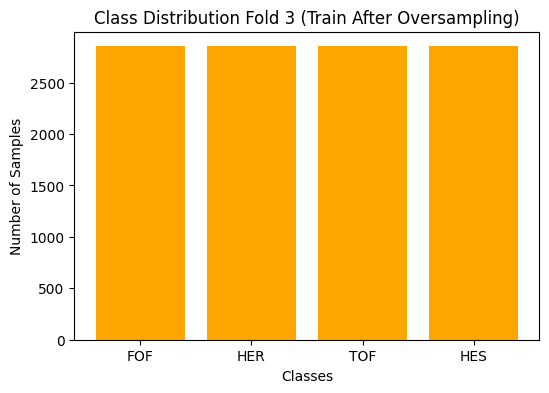

/tmp/ipython-input-444597368.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: LR=0.000050 | Train Acc=0.413 | Val Acc=0.411
Epoch 1: Train Acc=0.413 | Val Acc=0.411
Best model saved at epoch 1 with Val Acc=0.4108
Epoch 2: LR=0.000050 | Train Acc=0.551 | Val Acc=0.475
Epoch 2: Train Acc=0.551 | Val Acc=0.475
Best model saved at epoch 2 with Val Acc=0.4753
Epoch 3: LR=0.000050 | Train Acc=0.618 | Val Acc=0.562
Epoch 3: Train Acc=0.618 | Val Acc=0.562
Best model saved at epoch 3 with Val Acc=0.5620
Epoch 4: LR=0.000050 | Train Acc=0.647 | Val Acc=0.485
Epoch 4: Train Acc=0.647 | Val Acc=0.485
Epoch 5: LR=0.000050 | Train Acc=0.677 | Val Acc=0.581
Epoch 5: Train Acc=0.677 | Val Acc=0.581
Best model saved at epoch 5 with Val Acc=0.5806
Epoch 6: LR=0.000050 | Train Acc=0.693 | Val Acc=0.573
Epoch 6: Train Acc=0.693 | Val Acc=0.573
Epoch 7: LR=0.000050 | Train Acc=0.718 | Val Acc=0.581
Epoch 7: Train Acc=0.718 | Val Acc=0.581
Best model saved at epoch 7 with Val Acc=0.5814
Epoch 8: LR=0.000050 | Train Acc=0.728 | Val Acc=0.609
Epoch 8: Train Acc=0.728 | Val Ac

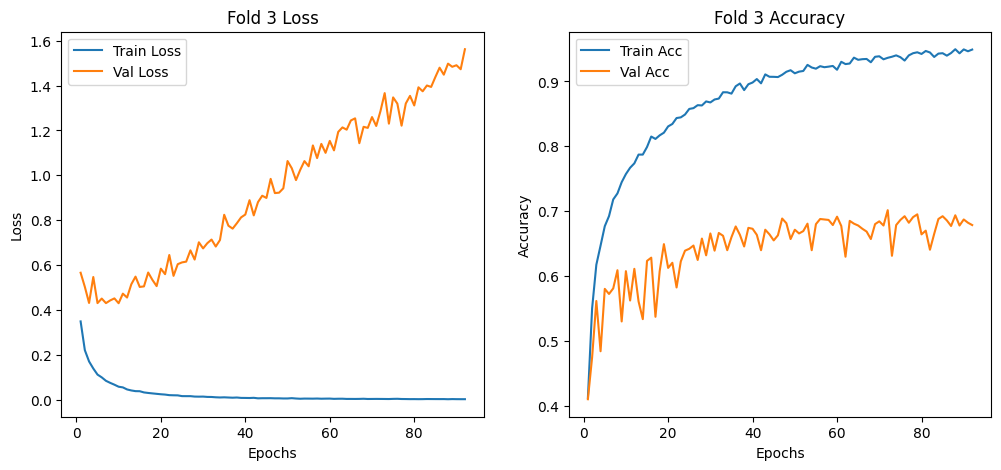

Fold 3 Final: Acc=0.679 Prec=0.690 Rec=0.679 F1=0.681


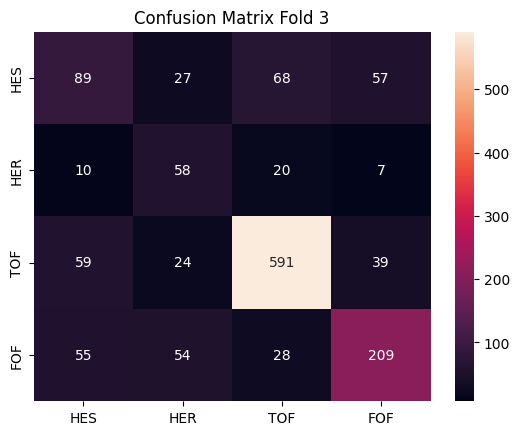


===== Fold 4/5 =====
After oversampling: Counter({np.int64(3): 2853, np.int64(2): 2853, np.int64(1): 2853, np.int64(0): 2853})


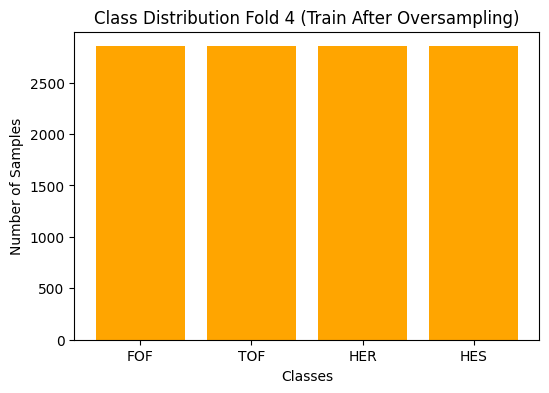

/tmp/ipython-input-444597368.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: LR=0.000050 | Train Acc=0.419 | Val Acc=0.347
Epoch 1: Train Acc=0.419 | Val Acc=0.347
Best model saved at epoch 1 with Val Acc=0.3472
Epoch 2: LR=0.000050 | Train Acc=0.542 | Val Acc=0.507
Epoch 2: Train Acc=0.542 | Val Acc=0.507
Best model saved at epoch 2 with Val Acc=0.5072
Epoch 3: LR=0.000050 | Train Acc=0.601 | Val Acc=0.487
Epoch 3: Train Acc=0.601 | Val Acc=0.487
Epoch 4: LR=0.000050 | Train Acc=0.637 | Val Acc=0.577
Epoch 4: Train Acc=0.637 | Val Acc=0.577
Best model saved at epoch 4 with Val Acc=0.5775
Epoch 5: LR=0.000050 | Train Acc=0.666 | Val Acc=0.525
Epoch 5: Train Acc=0.666 | Val Acc=0.525
Epoch 6: LR=0.000050 | Train Acc=0.692 | Val Acc=0.592
Epoch 6: Train Acc=0.692 | Val Acc=0.592
Best model saved at epoch 6 with Val Acc=0.5918
Epoch 7: LR=0.000050 | Train Acc=0.713 | Val Acc=0.600
Epoch 7: Train Acc=0.713 | Val Acc=0.600
Best model saved at epoch 7 with Val Acc=0.5997
Epoch 8: LR=0.000050 | Train Acc=0.725 | Val Acc=0.611
Epoch 8: Train Acc=0.725 | Val Ac

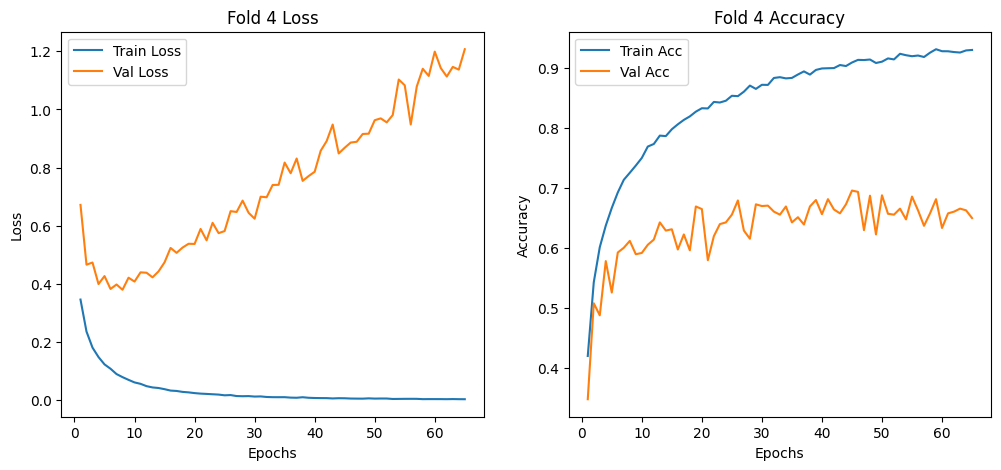

Fold 4 Final: Acc=0.649 Prec=0.671 Rec=0.649 F1=0.657


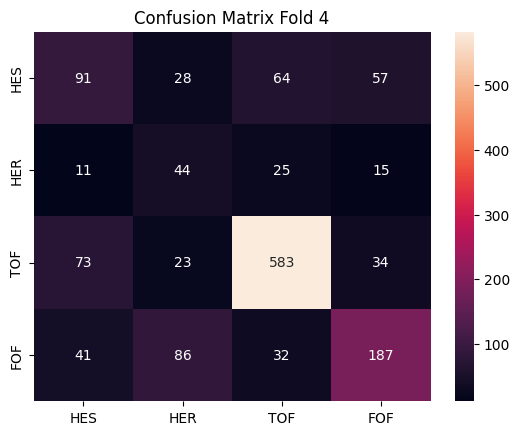


===== Fold 5/5 =====
After oversampling: Counter({np.int64(3): 2853, np.int64(2): 2853, np.int64(1): 2853, np.int64(0): 2853})


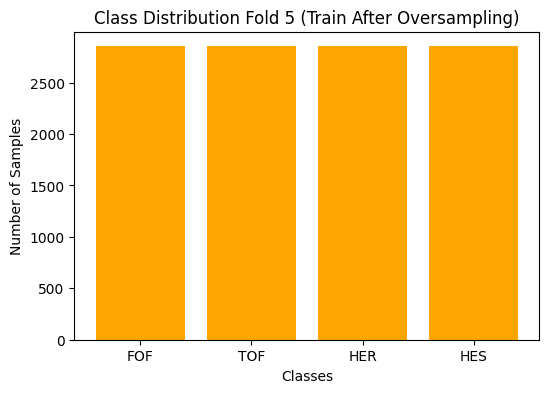

/tmp/ipython-input-444597368.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: LR=0.000050 | Train Acc=0.425 | Val Acc=0.347
Epoch 1: Train Acc=0.425 | Val Acc=0.347
Best model saved at epoch 1 with Val Acc=0.3472
Epoch 2: LR=0.000050 | Train Acc=0.545 | Val Acc=0.499
Epoch 2: Train Acc=0.545 | Val Acc=0.499
Best model saved at epoch 2 with Val Acc=0.4993
Epoch 3: LR=0.000050 | Train Acc=0.601 | Val Acc=0.444
Epoch 3: Train Acc=0.601 | Val Acc=0.444
Epoch 4: LR=0.000050 | Train Acc=0.637 | Val Acc=0.473
Epoch 4: Train Acc=0.637 | Val Acc=0.473
Epoch 5: LR=0.000050 | Train Acc=0.662 | Val Acc=0.537
Epoch 5: Train Acc=0.662 | Val Acc=0.537
Best model saved at epoch 5 with Val Acc=0.5373
Epoch 6: LR=0.000050 | Train Acc=0.675 | Val Acc=0.562
Epoch 6: Train Acc=0.675 | Val Acc=0.562
Best model saved at epoch 6 with Val Acc=0.5624
Epoch 7: LR=0.000050 | Train Acc=0.698 | Val Acc=0.496
Epoch 7: Train Acc=0.698 | Val Acc=0.496
Epoch 8: LR=0.000050 | Train Acc=0.712 | Val Acc=0.541
Epoch 8: Train Acc=0.712 | Val Acc=0.541
Epoch 9: LR=0.000050 | Train Acc=0.733 |

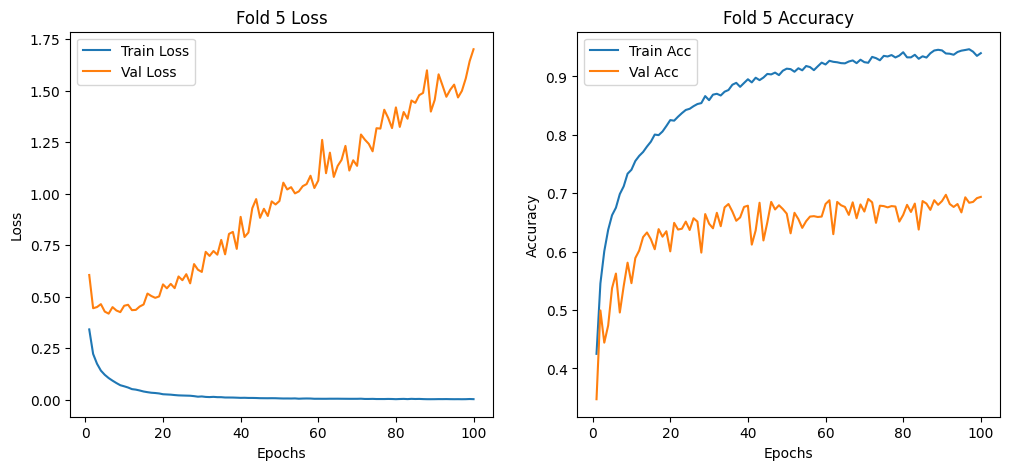

Fold 5 Final: Acc=0.694 Prec=0.693 Rec=0.694 F1=0.693


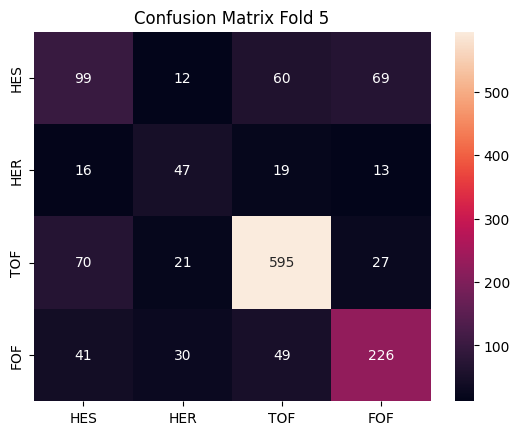


Average: acc     0.683060
prec    0.691031
rec     0.683060
f1      0.685230
dtype: float64


,fold,acc,prec,rec,f1
0,1,0.691756,0.701083,0.691756,0.695011
1,2,0.701792,0.700269,0.701792,0.700181
2,3,0.678853,0.689817,0.678853,0.681361
3,4,0.649211,0.671079,0.649211,0.656594
4,5,0.693687,0.692909,0.693687,0.693000


In [9]:
cross_validate(frames,labels,'/content/drive/MyDrive/IMU/kFold_Results_ActivityRecog_new',k=5,epochs=100,batch_size=32,lr=5e-5)